### Notebook that reads the output of FMDeg from TCGA dataset and visualize the scatter plot of the output

### Read data 

In [33]:
import pandas as pd
import numpy as np
import os
import re
import glob
import json
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerPathCollection
import statsmodels.stats.multitest as mt


### paths

In [34]:
base_output = "/../../../data/output_methods_selection/"
output_path = os.path.join(base_output,"output_fmdeg_degrons_paper_tcga_penta")
base="../../../" 
# Path degrons
path_regions = os.path.join(base,"data","coordinates_degrons.tsv.gz")
path_all_degrons = os.path.join(base,"data","predicte_degrons_properties.tsv.gz")
# Path mutations CCDS
path_output_missense_degrons = os.path.join(base,"data","missense_clean_type.tsv.gz")
# Outputs
path_output_all = os.path.join(base,"data","fmdeg_degrons_tcga_penta.tsv")
path_output_significant = os.path.join(base,"data","fmdeg_degrons_tcga_penta_significant.tsv")
path_output_ppi = os.path.join(base,"data","fmdeg_degrons_tcga_penta_significant_ppi.tsv")
# Role data
role_data = os.path.join(base,"external","gene_MoA.tsv")
# Plots 
path_output_plots = os.path.join(base,"plots","Figure5")


# Aux functions

In [35]:
def load_deg(regex,globf):
    p = re.compile(regex)#"/workspace/users/fmartinez/annotation_ubiquitins/output_fml_ttype_paper/mutations_input_([A-Z]+)-oncodrivefml.tsv"
    l = []
    for filef in glob.glob(globf):#"/workspace/users/fmartinez/annotation_ubiquitins/output_fml_ttype_paper/mutations_input_*-oncodrivefml.tsv"
        
        ttype = re.search(p,filef).group(1)

        df = pd.read_csv(filef,sep="\t")

        df["Cancer_Type"] = ttype
        
        df.rename(columns={"DEGRON":"GENE_ID"},inplace=True)
        
        if df.shape[0] >0:
            #print (filef)
            df=df[np.isfinite(df["P_VALUE"])]
            if df.shape[0] > 0:
                df["DEGRON"] = df.apply(lambda row: row["GENE_ID"].split(":")[1],axis=1)
                df["Entry_Isoform"] = df.apply(lambda row: row["GENE_ID"].split(":")[0],axis=1)
                df["STARTF"] = df.apply(lambda row: int(row["GENE_ID"].split(":")[2]),axis=1)
                df["STOPF"] = df.apply(lambda row: int(row["GENE_ID"].split(":")[3]),axis=1)
                df["Q_VALUE"]=mt.fdrcorrection(df["P_VALUE"],alpha=0.05)[1]
                l.append(df)
    df_total = pd.concat(l)
    return df_total

def match_df_degrons(df_output):
   
    df_regions_info = pd.read_csv(path_regions,sep="\t",compression="gzip")
    df_degrons = pd.read_csv(path_all_degrons,sep="\t",compression="gzip")
    df_regions_info.START_FLANKING = df_regions_info.START_FLANKING.astype(int)
    df_regions_info.END_FLANKING = df_regions_info.END_FLANKING.astype(int)
    df_regions_info.START = df_regions_info.START.astype(int)
    df_regions_info.END = df_regions_info.END.astype(int)
    df_fml = pd.merge(left=df_regions_info[["Entry_Isoform","DEGRON","START_FLANKING","END_FLANKING","START","END"]],right=df_output,left_on=["Entry_Isoform","DEGRON","START_FLANKING","END_FLANKING"],right_on=["Entry_Isoform","DEGRON","STARTF","STOPF"])
    df_fml = pd.merge(left=df_fml,right=df_degrons,how="left")
    # Only retain the CCDS of mutatiions from TCGA
    df_data = pd.read_csv(path_output_missense_degrons,sep="\t",compression="gzip")
    df_fml_degron = pd.merge(df_fml,df_data[["CCDS","Entry_Isoform"]].drop_duplicates())
    return df_fml_degron
def get_fmdeg():
    df = load_deg(output_path+"/([A-Z]+)-fmdeg.tsv",output_path+"/*-fmdeg.tsv")
    return match_df_degrons(df)
def get_odd_ratio(row):
    a = (row["OBSERVED_REGION"])
    b =  (row["TOTAL_MUTS_GENE"] - row["OBSERVED_REGION"]) 
    c =  (row["MEAN_SIMULATED"] )
    d =  (row["TOTAL_MUTS_GENE"] - row["MEAN_SIMULATED"])
    if (b==0):
        return a
    elif (c==0) or (d==0):
        return np.nan
    return (a/b) / (c/d)
def set_color(row,colors):
    if row["Cancer_Type"] in colors:
        return colors[row["Cancer_Type"]]
    else:
        return "black"

# Read FMDeg

### We defined as significant:
-- Tumor types:  effect_size > 1 and Q_VALUE <0.1


In [36]:
df_fml_degron_ttype = get_fmdeg()
df_fml_degron_ttype = df_fml_degron_ttype[["Hugo_Symbol","CCDS","Entry_Isoform","DEGRON","START","END","Annotated","Prob_DEGRON","Cancer_Type","NMUTS","P_VALUE","Q_VALUE","OBSERVED_MEAN","SIMULATED_MEAN","PPI","Class"]].drop_duplicates()
df_fml_degron_ttype["P_VALUE_FI_TCGA"] = df_fml_degron_ttype.apply(lambda row: float("{0:.2E}".format(row["P_VALUE"])),axis=1)
df_fml_degron_ttype["Q_VALUE_FI_TCGA"] = df_fml_degron_ttype.apply(lambda row: float("{0:.2E}".format((row["Q_VALUE"]))),axis=1)
df_fml_degron_ttype["effect_size_fm"] = df_fml_degron_ttype.apply(lambda row: float("{0:.2E}".format((np.log2((row["OBSERVED_MEAN"]/row["SIMULATED_MEAN"])+1)))),axis=1)
df_fml_degron_ttype["log_pvalue_fm"] = df_fml_degron_ttype.apply(lambda row: -np.log10(row["P_VALUE_FI_TCGA"]),axis=1)
df_fml_degron_ttype["log_qvalue_fm"] = df_fml_degron_ttype.apply(lambda row: -np.log10(row["Q_VALUE_FI_TCGA"]),axis=1)
df_fml_degron_ttype.drop(columns=["P_VALUE"],inplace=True)
df_fml_degron_ttype["significant_FM"] = df_fml_degron_ttype.apply(lambda row: True if row["effect_size_fm"]>1 and row["NMUTS"]>=2 and row["Q_VALUE_FI_TCGA"] < 0.1 else  False,axis=1)
df_fml_degron_ttype["nearly_significant_FM"] = df_fml_degron_ttype.apply(lambda row: True if row["effect_size_fm"]>1 and row["NMUTS"]>=2 and row["Q_VALUE_FI_TCGA"] < 0.25 else  False,axis=1)

### Save two dataframes one for all significant other significant + PPI

In [37]:
names_degrons = {"CBL_APS":"CBL (APS motif)","CBL_MET":"CBL (MET motif)","CBL_PTK":"CBL (PTK motif)","DEG_APCC_DBOX_1":"APC D box","DEG_APCC_KENBOX_2":"APC KEN box",
                "DEG_APCC_TPR_1":"APC TPR motif","DEG_COP1_1": "COP1 motif","DEG_CRL4_CDT2_1":"PIP motif of DTL","DEG_CRL4_CDT2_2":"PIP 2nd motif of DTL","DEG_Kelch_KLHL3_1":"KLHL3/KLH2 motif","DEG_Kelch_Keap1_1":"KEAP1 motif 1",
                "DEG_Kelch_Keap1_2":"KEAP1 motif 2","DEG_Kelch_actinfilin_1":"KLHL17 motif","DEG_MDM2_SWIB_1":"MDM2 motif","DEG_ODPH_VHL_1":"VHL motif","DEG_SCF_FBW7_1":"FBXW7 motif 1",
                "DEG_SCF_FBW7_2":"FBXW7 motif 2","DEG_SCF_SKP2-CKS1_1":"SKP2 Fbox motif","DEG_SCF_TRCP1_1":"BTRCP motif","DEG_SIAH_1":"SIAH motif","DEG_SPOP_SBC_1":"SPOP motif",
                "ITCH":"ITCH motif","LIG_APCC_ABBA_1":"APC ABBA motif","LIG_APCC_Cbox_1":"APC Cbox motif","SCF_FBXO31":"FBX031 motif","_GLOBAL_DEGRON":"_MEAN degron","DEG_SCF_COI1_1":"SCF-LRR-degron","DEG_SCF_TIR1_1":"SCF-TIR1-degron",
                "LIG_APCC_ABBAyCdc20_2":"APC ABBA/Cdc20","SCF_FBXL2":"FBXL2 motif"}
df_fml_degron_ttype["MANUSCRIPT_ID"] = df_fml_degron_ttype.apply(lambda row: names_degrons[row["DEGRON"]],axis=1)

In [38]:
df_fml_degron_ttype[["Hugo_Symbol","Entry_Isoform","DEGRON","MANUSCRIPT_ID","START","END","effect_size_fm","log_pvalue_fm","Cancer_Type","P_VALUE_FI_TCGA","Class","significant_FM","log_qvalue_fm","Q_VALUE_FI_TCGA","nearly_significant_FM","NMUTS"]].sort_values("Q_VALUE_FI_TCGA").to_csv(path_output_all,sep="\t",index=False)

### define colors

In [39]:
dict_colors = json.load(open("dict_colors.json",'r'))

# Plot FM

### Prepare plots

In [40]:
df_fml_degron_ttype["color"] = df_fml_degron_ttype.apply(lambda row:set_color(row,dict_colors),axis=1)
df_fml_degron_ttype["lw"] = df_fml_degron_ttype.apply(lambda row: 0.5 if row["PPI"] > 0.0 else 0.0,axis=1)
df_fml_degron_ttype["ed"] = df_fml_degron_ttype.apply(lambda row: "black" if row["PPI"] > 0.0 else row["color"],axis=1)


### Matplotlib

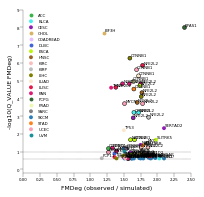

In [41]:
fig,ax = plt.subplots(figsize=(3,3))
df_sigs = df_fml_degron_ttype[(df_fml_degron_ttype["nearly_significant_FM"])]
df_not_sigs = df_fml_degron_ttype[~(df_fml_degron_ttype["nearly_significant_FM"])].sample(frac=0.0)
for cancer_type in df_sigs["Cancer_Type"].unique():
    ys = df_sigs[df_sigs["Cancer_Type"]==cancer_type]["log_qvalue_fm"].values
    xs = df_sigs[df_sigs["Cancer_Type"]==cancer_type]["effect_size_fm"].values
    lws = df_sigs[df_sigs["Cancer_Type"]==cancer_type]["lw"].values
    ecs = df_sigs[df_sigs["Cancer_Type"]==cancer_type]["ed"].values
    sc=ax.scatter(x=xs,y=ys,color=dict_colors[cancer_type],s=15,linewidths=lws,label=cancer_type,marker="o",edgecolors=ecs)
    for i in range(len(xs)):
        ax.annotate(xy=(xs[i]+0.01,ys[i]+0.1),s=df_sigs[(df_sigs["Cancer_Type"]==cancer_type)]["Hugo_Symbol"].values[i],fontsize=4,fontweight="normal")
        pass

ax.scatter(x=df_not_sigs["effect_size_fm"].values,y=df_not_sigs["log_qvalue_fm"].values,color="grey",s=10,alpha=0.5,linewidths=0)

# Set legend
marker_size = 15
handles, labels = ax.get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
def update_prop(handle, orig):
    handle.update_from(orig)
    handle.set_sizes([marker_size])
    handle.set_linewidth(0)
ax.legend(handler_map={type(sc): HandlerPathCollection(update_func=update_prop)},scatterpoints=1, frameon=False, labelspacing=0.5, markerscale=1,loc="upper left",fontsize=4,labels=labels,handles=handles)

# Adjust axis
ax.set_ylabel("-log10(Q_VALUE FMDeg)",fontsize=6)
ax.set_xlabel("FMDeg (observed / simulated)",fontsize=6)
ylim = (-0.2,9)
ax.set_ylim(ylim)
ax.set_yticks([x for x in range(int(ylim[0]),ylim[1]+1,1)])
xlim = (0,2.5)
ax.set_xlim(xlim)
ax.set_xticks([x for x in np.arange(xlim[0],xlim[1]+0.25,0.25)])
ax.tick_params(axis = 'y', labelsize =4  , pad=0.5 ,width=0.25)
ax.tick_params(axis = 'x', labelsize =4  , pad=0.5 ,width=0.25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.25)
ax.spines['bottom'].set_linewidth(0.25)
ax.axhline(y=-np.log10(0.1),xmin=0,xmax=np.nanmax(df_sigs["effect_size_fm"].values),color="black",ls="--",lw=0.2)
ax.axhline(y=-np.log10(0.25),xmin=0,xmax=np.nanmax(df_sigs["effect_size_fm"].values),color="black",ls="--",lw=0.2)
plt.savefig(path_output_plots+'/FM_all_tcga_penta.pdf', dpi=100,bbox_inches="tight")
None

### FM and DeGRON 

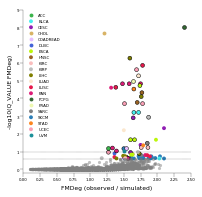

In [24]:
fig,ax = plt.subplots(figsize=(3,3))
df_sigs = df_fml_degron_ttype[(df_fml_degron_ttype["nearly_significant_FM"])]
df_not_sigs = df_fml_degron_ttype[~(df_fml_degron_ttype["nearly_significant_FM"])]
for cancer_type in df_sigs["Cancer_Type"].unique():
    ys = df_sigs[df_sigs["Cancer_Type"]==cancer_type]["log_qvalue_fm"].values
    xs = df_sigs[df_sigs["Cancer_Type"]==cancer_type]["effect_size_fm"].values
    lws = df_sigs[df_sigs["Cancer_Type"]==cancer_type]["lw"].values
    ecs = df_sigs[df_sigs["Cancer_Type"]==cancer_type]["ed"].values
    sc=ax.scatter(x=xs,y=ys,color=dict_colors[cancer_type],s=15,linewidths=lws,label=cancer_type,marker="o",edgecolors=ecs)
    for i in range(len(xs)):
        #ax.annotate(xy=(xs[i]+0.01,ys[i]+0.1),s=df_sigs[(df_sigs["Cancer_Type"]==cancer_type)]["Hugo_Symbol"].values[i],fontsize=4,fontweight="normal")
        pass

ax.scatter(x=df_not_sigs["effect_size_fm"].values,y=df_not_sigs["log_qvalue_fm"].values,color="grey",s=10,alpha=0.5,linewidths=0)




ax.set_ylabel("-log10(Q_VALUE FMDeg)",fontsize=6)
ax.set_xlabel("FMDeg (observed / simulated)",fontsize=6)
marker_size = 15
handles, labels = ax.get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
def update_prop(handle, orig):
    handle.update_from(orig)
    handle.set_sizes([marker_size])
    handle.set_linewidth(0)
ax.legend(handler_map={type(sc): HandlerPathCollection(update_func=update_prop)},scatterpoints=1, frameon=False, labelspacing=0.5, markerscale=1,loc="upper left",fontsize=4,labels=labels,handles=handles, )

#x=ax.legend()
# Adjust axis
ylim = (-0.2,9)
ax.set_ylim(ylim)
ax.set_yticks([x for x in range(int(ylim[0]),ylim[1]+1,1)])
xlim = (0,2.5)
ax.set_xlim(xlim)
ax.set_xticks([x for x in np.arange(xlim[0],xlim[1]+0.25,0.25)])
ax.tick_params(axis = 'y', labelsize =4  , pad=0.5 ,width=0.25)
ax.tick_params(axis = 'x', labelsize =4  , pad=0.5 ,width=0.25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.25)
ax.spines['bottom'].set_linewidth(0.25)
ax.axhline(y=-np.log10(0.1),xmin=0,xmax=np.nanmax(df_sigs["effect_size_fm"].values),color="black",ls="--",lw=0.2)
ax.axhline(y=-np.log10(0.25),xmin=0,xmax=np.nanmax(df_sigs["effect_size_fm"].values),color="black",ls="--",lw=0.2)
plt.savefig(path_output_plots+'/FM_all_tcga_penta.png', dpi=900,bbox_inches="tight")
None

### Finally check enrichment in oncogenes

In [29]:
df_roles = pd.read_csv(role_data,sep="\t")
df_roles["Hugo_Symbol"] = df_roles["gene"]
df_roles["ROLE"] = df_roles["gene_MoA"]

In [30]:
df_fml_degron_ttype = df_fml_degron_ttype.merge(df_roles[["Hugo_Symbol","ROLE"]],how="left")
df_fml_degron_ttype["ROLE"].fillna("Unknown",inplace=True)

### Perform an statistical test to measure enrichment of oncogenes

In [31]:
from scipy import stats

### unique

In [32]:
x=df_fml_degron_ttype

In [33]:
sa = set(x[(x["significant_FM"])&(x["ROLE"]=="Act")]["Hugo_Symbol"].values)
a=len(sa)
sb = set(x[(x["significant_FM"])&(x["ROLE"]!="Act")]["Hugo_Symbol"].values)
b=len(sb)
sc = set(x[(~x["significant_FM"])&(x["ROLE"]=="Act")]["Hugo_Symbol"].values)
c = len(sc.difference(sa))
sd = set(x[(~x["significant_FM"])&(x["ROLE"]!="Act")]["Hugo_Symbol"].values)
d = len(sd.difference(sb))
print (stats.fisher_exact([[a,b],[c,d]]),a,b,c,d)

(15.15625, 0.0001070127479706416) 5 8 116 2813


### non-unique

In [34]:
a = len(df_fml_degron_ttype[(df_fml_degron_ttype["significant_FM"])&(df_fml_degron_ttype["ROLE"]=="Act")]["Hugo_Symbol"].values)
b = len(df_fml_degron_ttype[(df_fml_degron_ttype["significant_FM"])&(df_fml_degron_ttype["ROLE"]!="Act")]["Hugo_Symbol"].values)
c = len(df_fml_degron_ttype[(~df_fml_degron_ttype["significant_FM"])&(df_fml_degron_ttype["ROLE"]=="Act")]["Hugo_Symbol"].values)
d = len(df_fml_degron_ttype[(~df_fml_degron_ttype["significant_FM"])&(df_fml_degron_ttype["ROLE"]!="Act")]["Hugo_Symbol"].values)
stats.fisher_exact([[a,b],[c,d]])

(72.8013029315961, 9.718658608264328e-33)

### MYCN

In [35]:
df_fml_degron_ttype[df_fml_degron_ttype["Hugo_Symbol"]=="MYCN"][["Cancer_Type","Q_VALUE_FI_TCGA","DEGRON"]]

Cancer_Type  Q_VALUE_FI_TCGA          DEGRON
629        UCEC         0.000198  DEG_SCF_FBW7_2
630        SKCM         0.751000  DEG_SCF_FBW7_2
631         PAN         0.092900  DEG_SCF_FBW7_2

### CCND1

In [36]:
df_fml_degron_ttype[df_fml_degron_ttype["Hugo_Symbol"]=="CCND1"]

Hugo_Symbol        CCDS Entry_Isoform      DEGRON  START  END Annotated  \
938       CCND1  CCDS8191.1      P24385-1  SCF_FBXO31    287  295        NO   
939       CCND1  CCDS8191.1      P24385-1  SCF_FBXO31    287  295        NO   
940       CCND1  CCDS8191.1      P24385-1  SCF_FBXO31    287  295        NO   
941       CCND1  CCDS8191.1      P24385-1  SCF_FBXO31    287  295        NO   

     Prob_DEGRON Cancer_Type  NMUTS  ...  Q_VALUE_FI_TCGA  effect_size_fm  \
938        0.915        CESC      2  ...           0.5870            1.31   
939        0.915        HNSC      2  ...           0.9500            1.05   
940        0.915        UCEC     13  ...           0.1100            1.27   
941        0.915         PAN     20  ...           0.0632            1.33   

     log_pvalue_fm  log_qvalue_fm significant_FM  nearly_significant_FM  \
938       0.681937       0.231362          False                  False   
939       0.423659       0.022276          False                  False   
940       2.560667       0.958607          False                   True   
941       4.229148       1.199283           True                   True   

       color   lw     ed  ROLE  
938  #911eb4  0.5  black   Act  
939  #9a6324  0.5  black   Act  
940  #fa9fb5  0.5  black   Act  
941  #dd1c77  0.5  black   Act  

[4 rows x 26 columns]

### EPAS1

In [37]:
df_fml_degron_ttype[df_fml_degron_ttype["Hugo_Symbol"]=="EPAS1"]

Hugo_Symbol        CCDS Entry_Isoform          DEGRON  START  END  \
3342       EPAS1  CCDS1825.1      Q99814-1  DEG_ODPH_VHL_1    403  416   
3343       EPAS1  CCDS1825.1      Q99814-1  DEG_ODPH_VHL_1    529  542   
3344       EPAS1  CCDS1825.1      Q99814-1  DEG_ODPH_VHL_1    529  542   
3345       EPAS1  CCDS1825.1      Q99814-1  DEG_ODPH_VHL_1    529  542   
3346       EPAS1  CCDS1825.1      Q99814-1  DEG_SPOP_SBC_1    465  469   
3347       EPAS1  CCDS1825.1      Q99814-1  DEG_SPOP_SBC_1    465  469   

     Annotated  Prob_DEGRON Cancer_Type  NMUTS  ...  Q_VALUE_FI_TCGA  \
3342       YES       0.9074         PAN      2  ...     8.640000e-01   
3343       YES       0.8644        PCPG      8  ...     1.000000e-08   
3344       YES       0.8644        STAD      2  ...     1.000000e+00   
3345       YES       0.8644         PAN     13  ...     8.190000e-01   
3346        NO       0.5935        UCEC      2  ...     9.970000e-01   
3347        NO       0.5935         PAN      3  ...     1.000000e+00   

      effect_size_fm  log_pvalue_fm  log_qvalue_fm significant_FM  \
3342           1.450       1.220404       0.063486          False   
3343           2.400       8.000000       8.000000           True   
3344           0.281       0.012781      -0.000000          False   
3345           1.300       1.889410       0.086716          False   
3346           0.697       0.133122       0.001305          False   
3347           0.711       0.116339      -0.000000          False   

      nearly_significant_FM    color   lw       ed     ROLE  
3342                  False  #dd1c77  0.5    black  Unknown  
3343                   True  #336633  0.5    black  Unknown  
3344                  False  #fc8520  0.5    black  Unknown  
3345                  False  #dd1c77  0.5    black  Unknown  
3346                  False  #fa9fb5  0.0  #fa9fb5  Unknown  
3347                  False  #dd1c77  0.0  #dd1c77  Unknown  

[6 rows x 26 columns]

### Two examples tri versus penta

In [48]:
x=df_fml_degron_ttype[df_fml_degron_ttype["Cancer_Type"]=="LIHC"]

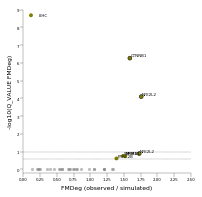

In [49]:
fig,ax = plt.subplots(figsize=(3,3))
df_sigs = x[(x["nearly_significant_FM"])]
df_not_sigs = x[~(x["nearly_significant_FM"])].sample(frac=1.0)
for cancer_type in df_sigs["Cancer_Type"].unique():
    ys = df_sigs[df_sigs["Cancer_Type"]==cancer_type]["log_qvalue_fm"].values
    xs = df_sigs[df_sigs["Cancer_Type"]==cancer_type]["effect_size_fm"].values
    lws = df_sigs[df_sigs["Cancer_Type"]==cancer_type]["lw"].values
    ecs = df_sigs[df_sigs["Cancer_Type"]==cancer_type]["ed"].values
    sc=ax.scatter(x=xs,y=ys,color=dict_colors[cancer_type],s=15,linewidths=lws,label=cancer_type,marker="o",edgecolors=ecs)
    for i in range(len(xs)):
        ax.annotate(xy=(xs[i]+0.01,ys[i]+0.1),s=df_sigs[(df_sigs["Cancer_Type"]==cancer_type)]["Hugo_Symbol"].values[i],fontsize=4,fontweight="normal")
        pass

ax.scatter(x=df_not_sigs["effect_size_fm"].values,y=df_not_sigs["log_qvalue_fm"].values,color="grey",s=10,alpha=0.5,linewidths=0)

# Set legend
marker_size = 15
handles, labels = ax.get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
def update_prop(handle, orig):
    handle.update_from(orig)
    handle.set_sizes([marker_size])
    handle.set_linewidth(0)
ax.legend(handler_map={type(sc): HandlerPathCollection(update_func=update_prop)},scatterpoints=1, frameon=False, labelspacing=0.5, markerscale=1,loc="upper left",fontsize=4,labels=labels,handles=handles)

# Adjust axis
ax.set_ylabel("-log10(Q_VALUE FMDeg)",fontsize=6)
ax.set_xlabel("FMDeg (observed / simulated)",fontsize=6)
ylim = (-0.2,9)
ax.set_ylim(ylim)
ax.set_yticks([x for x in range(int(ylim[0]),ylim[1]+1,1)])
xlim = (0,2.5)
ax.set_xlim(xlim)
ax.set_xticks([x for x in np.arange(xlim[0],xlim[1]+0.25,0.25)])
ax.tick_params(axis = 'y', labelsize =4  , pad=0.5 ,width=0.25)
ax.tick_params(axis = 'x', labelsize =4  , pad=0.5 ,width=0.25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.25)
ax.spines['bottom'].set_linewidth(0.25)
ax.axhline(y=-np.log10(0.1),xmin=0,xmax=np.nanmax(df_sigs["effect_size_fm"].values),color="black",ls="--",lw=0.2)
ax.axhline(y=-np.log10(0.25),xmin=0,xmax=np.nanmax(df_sigs["effect_size_fm"].values),color="black",ls="--",lw=0.2)
plt.savefig(path_output_plots+'/FM_example_LIHC_penta.pdf', dpi=100,bbox_inches="tight")
None

In [51]:
x=df_fml_degron_ttype[df_fml_degron_ttype["Cancer_Type"]=="PAN"]

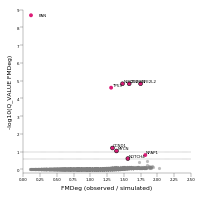

In [53]:
fig,ax = plt.subplots(figsize=(3,3))
df_sigs = x[(x["nearly_significant_FM"])]
df_not_sigs = x[~(x["nearly_significant_FM"])].sample(frac=1.0)
for cancer_type in df_sigs["Cancer_Type"].unique():
    ys = df_sigs[df_sigs["Cancer_Type"]==cancer_type]["log_qvalue_fm"].values
    xs = df_sigs[df_sigs["Cancer_Type"]==cancer_type]["effect_size_fm"].values
    lws = df_sigs[df_sigs["Cancer_Type"]==cancer_type]["lw"].values
    ecs = df_sigs[df_sigs["Cancer_Type"]==cancer_type]["ed"].values
    sc=ax.scatter(x=xs,y=ys,color=dict_colors[cancer_type],s=15,linewidths=lws,label=cancer_type,marker="o",edgecolors=ecs)
    for i in range(len(xs)):
        ax.annotate(xy=(xs[i]+0.01,ys[i]+0.1),s=df_sigs[(df_sigs["Cancer_Type"]==cancer_type)]["Hugo_Symbol"].values[i],fontsize=4,fontweight="normal")
        pass

ax.scatter(x=df_not_sigs["effect_size_fm"].values,y=df_not_sigs["log_qvalue_fm"].values,color="grey",s=10,alpha=0.5,linewidths=0)

# Set legend
marker_size = 15
handles, labels = ax.get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
def update_prop(handle, orig):
    handle.update_from(orig)
    handle.set_sizes([marker_size])
    handle.set_linewidth(0)
ax.legend(handler_map={type(sc): HandlerPathCollection(update_func=update_prop)},scatterpoints=1, frameon=False, labelspacing=0.5, markerscale=1,loc="upper left",fontsize=4,labels=labels,handles=handles)

# Adjust axis
ax.set_ylabel("-log10(Q_VALUE FMDeg)",fontsize=6)
ax.set_xlabel("FMDeg (observed / simulated)",fontsize=6)
ylim = (-0.2,9)
ax.set_ylim(ylim)
ax.set_yticks([x for x in range(int(ylim[0]),ylim[1]+1,1)])
xlim = (0,2.5)
ax.set_xlim(xlim)
ax.set_xticks([x for x in np.arange(xlim[0],xlim[1]+0.25,0.25)])
ax.tick_params(axis = 'y', labelsize =4  , pad=0.5 ,width=0.25)
ax.tick_params(axis = 'x', labelsize =4  , pad=0.5 ,width=0.25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.25)
ax.spines['bottom'].set_linewidth(0.25)
ax.axhline(y=-np.log10(0.1),xmin=0,xmax=np.nanmax(df_sigs["effect_size_fm"].values),color="black",ls="--",lw=0.2)
ax.axhline(y=-np.log10(0.25),xmin=0,xmax=np.nanmax(df_sigs["effect_size_fm"].values),color="black",ls="--",lw=0.2)
plt.savefig(path_output_plots+'/FM_example_PAN_penta.png', dpi=800,bbox_inches="tight")
None